# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW05] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [2]:
import copy
import numpy as np

from typing import List, NoReturn
from sklearn.datasets import make_blobs, make_moons

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [1]:
# like utils.py
def one_hot_encode(x):
    ohe = np.zeros((x.size, x.max() + 1))
    ohe[np.arange(x.size), x] = 1

    return ohe

def softmax(x):
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

In [9]:
class Module:
    """
    Абстрактный класс. Его менять не нужно.
    """    
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, d):
        raise NotImplementedError()
        
    def update(self, alpha):
        pass

In [10]:
# https://eli.thegreenplace.net/2018/backpropagation-through-a-fully-connected-layer/
class Linear(Module):
    """
    Линейный полносвязный слой.
    """
    def __init__(self, in_features: int, out_features: int):
        """
        Parameters
        ----------
        in_features : int
            Размер входа.
        out_features : int 
            Размер выхода.
    
        Notes
        -----
        W и b инициализируются случайно.
        """
        scale = 1 / np.sqrt(in_features)
        
        self.W = np.random.uniform(-scale, scale, (in_features, out_features))
        self.b = np.zeros((1, out_features))
        
    
    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Возвращает y = XW + b.

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
            То есть, либо x вектор с in_features элементов,
            либо матрица размерности (batch_size, in_features).
    
        Return
        ------
        y : np.ndarray
            Выход после слоя.
            Либо вектор с out_features элементами,
            либо матрица размерности (batch_size, out_features)

        """
        self.X = X
              
        return self.X @ self.W + self.b
    
    def backward(self, d: np.ndarray) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        self.dW = self.X.T @ d
        self.db = np.sum(d, axis=0, keepdims=True)
        
        return d @ self.W.T  # dX
        
    def update(self, alpha: float) -> NoReturn:
        """
        Обновляет W и b с заданной скоростью обучения.

        Parameters
        ----------
        alpha : float
            Скорость обучения.
        """
        self.W = self.W - alpha * self.dW
        self.b = self.b - alpha * self.db

In [5]:
class ReLU(Module):
    """
    Слой, соответствующий функции активации ReLU.
    """
    def __init__(self):
        super().__init__()
    
    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Возвращает y = max(0, x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        self.X = X

        return np.maximum(0, self.X)
        
    def backward(self, d) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        return d * (self.X >= 0)  # dX

# https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative
class CrossEntropyLoss(Module):
    """
    Слой, соответствующий функции активации Softmax и функции ошибки CrossEntropy.
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target):
        """
        Возвращает loss = CrossEntropyLoss(Softmax(input), target).

        Parameters
        ----------
        input : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        loss : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """        
        self.pred_prob = softmax(input)
        self.target = target
        
        return -np.sum(self.target * np.log(self.pred_prob)) / input.shape[0]
    
    def backward(self, d):
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        return self.pred_prob - self.target

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [11]:
class MLPClassifier:
    def __init__(self, modules: List[Module], epochs: int = 40, alpha: float = 0.01):
        """
        Parameters
        ----------
        modules : List[Module]
            Cписок, состоящий из ранее реализованных модулей и 
            описывающий слои нейронной сети. 
            В конец необходимо добавить Softmax.
        epochs : int
            Количество эпох обученияю
        alpha : float
            Cкорость обучения.
        """
        self.modules = modules
        self.loss = CrossEntropyLoss()
        
        self.epochs = epochs
        self.alpha = alpha
        
            
    def fit(self, X: np.ndarray, y: np.ndarray, batch_size=32) -> "MLPClassifier":
        """
        Обучает нейронную сеть заданное число эпох. 
        В каждой эпохе необходимо использовать cross-entropy loss для обучения, 
        а так же производить обновления не по одному элементу, а используя батчи.

        Parameters
        ----------
        X : np.ndarray
            Данные для обучения.
        y : np.ndarray
            Вектор меток классов для данных.
        batch_size : int
            Размер батча.
        """
        y = one_hot_encode(y)
        
        batch_idxs = np.arange(X.shape[0])
        
        for epoch in range(self.epochs):
            np.random.shuffle(batch_idxs)
            
            batches = np.array_split(batch_idxs, X.shape[0] / batch_size)
            
            for batch in batches:  
                out, y_batch = X[batch], y[batch]

                # Forward pass                
                for module in self.modules:
                    out = module.forward(out)
                    
                loss = self.loss.forward(out, y_batch)
                
                # Backward pass
                dout = self.loss.backward(1.0)
                
                for module in reversed(self.modules):
                    dout = module.backward(dout)
                    
                # Update pass
                for module in self.modules:
                    module.update(self.alpha)

        return self
        

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает вероятности классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Предсказанные вероятности классов для всех элементов X.
            Размерность (X.shape[0], n_classes)
        
        """
        out = X
        
        for module in self.modules:
            out = module.forward(out)
        
        return softmax(out)
        
    def predict(self, X) -> np.ndarray:
        """
        Предсказывает метки классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Вектор предсказанных классов
        
        """
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)

In [12]:
p = MLPClassifier([Linear(4, 64), ReLU(), Linear(64, 64), ReLU(), Linear(64, 2)])

X = np.random.randn(50, 4)
y = np.array([(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X])
p.fit(X, y)

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [13]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)

best_acc = 0
for _ in range(25):
    p = MLPClassifier([Linear(2, 64), ReLU(), Linear(64, 64), ReLU(), Linear(64, 2)])

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 1.0


In [14]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])

best_acc = 0
for _ in range(25):
    p = MLPClassifier([Linear(2, 4), ReLU(), Linear(4, 3)], alpha=0.02)

    p.fit(X, y, batch_size=64)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.96


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())

cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [37]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1) 
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10) 
    
    def forward(self, x):
        out = F.max_pool2d(F.relu(self.conv1(x)), 2, 2)
        out = F.max_pool2d(F.relu(self.conv2(out)), 2, 2)
        out = F.max_pool2d(F.relu(self.conv3(out)), 2, 2)
        
        out = out.reshape(out.shape[0], -1)
        
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))

        return F.softmax(self.fc3(out), dim=1)
        
def calculate_loss(X: torch.Tensor, y: torch.Tensor, model: Model):
    """
    Cчитает cross-entropy.

    Parameters
    ----------
    X : torch.Tensor
        Данные для обучения.
    y : torch.Tensor
        Метки классов.
    model : Model
        Модель, которую будем обучать.

    """
    y = F.one_hot(y)
    
    return -torch.sum(y * torch.log(model(X))) / X.shape[0]

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [38]:
def train(model, epochs=100):
    print("Training on: ", device)
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [44]:
model = LeNet().to(device)
train_l, test_l = train(model, epochs=30)

Training on:  cuda
Epoch 0 | Train loss 1.9789263423538208 | Test loss 1.7751423635482788
Epoch 1 | Train loss 1.658810901260376 | Test loss 1.5851565277099608
Epoch 2 | Train loss 1.5360827523040772 | Test loss 1.4826763645172119
Epoch 3 | Train loss 1.4365107352828979 | Test loss 1.387808642578125
Epoch 4 | Train loss 1.3684381185531616 | Test loss 1.3339225608825684
Epoch 5 | Train loss 1.3217397022628785 | Test loss 1.2939091512680054
Epoch 6 | Train loss 1.2716210437774658 | Test loss 1.260609478187561
Epoch 7 | Train loss 1.2451029084396363 | Test loss 1.2347089715957642
Epoch 8 | Train loss 1.206671739845276 | Test loss 1.190331555557251
Epoch 9 | Train loss 1.1769293631362916 | Test loss 1.1637034227371217
Epoch 10 | Train loss 1.1288994834136963 | Test loss 1.1250143587112427
Epoch 11 | Train loss 1.0982705466461182 | Test loss 1.1391019931793214
Epoch 12 | Train loss 1.0617405411529541 | Test loss 1.0769236766815184
Epoch 13 | Train loss 1.0342556587028504 | Test loss 1.05407

Построим график функции потерь

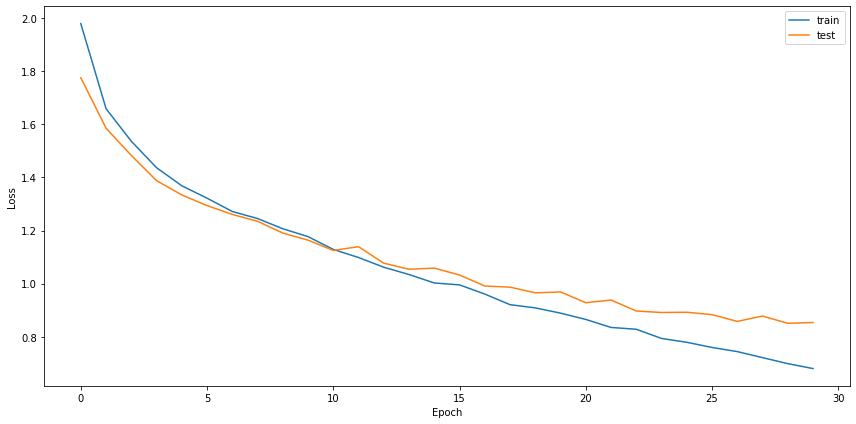

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [46]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.6999
Precision [0.76450893 0.87885986 0.59082218 0.52808989 0.61511424 0.58356417
 0.84987893 0.74571429 0.73038397 0.77012609]
Recall [0.685 0.74  0.618 0.47  0.7   0.632 0.702 0.783 0.875 0.794]
Mean Precision 0.7057062547320545
Mean Recall 0.6999000000000001
